In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import itertools as it

from bs4 import BeautifulSoup
import urllib.request


##### Используем данные: индекс потребительских цен, валютный курс, процентная ставка, денежная масса

In [2]:
def get_eom(year, month):
    
    buf_date_1 = datetime.datetime(year, month, 28)
    buf_date_2 = buf_date_1 + datetime.timedelta(days=4)
    res_date = buf_date_2 - datetime.timedelta(days=buf_date_2.day)

    return res_date

In [3]:
def get_trimmed_down(min_date, dates, values):
    
    while dates[0] < min_date:
        dates = dates[1:]
        values = values[1:]

    return dates, values
    

In [4]:
def get_trimmed_up(max_date, dates, values):
    
    while dates[-1] < max_date:
        buf_date = dates[-1] + datetime.timedelta(days=1)
        buf_date = get_eom(buf_date.year, buf_date.month)
        dates.append(buf_date)
        values.append(np.nan)

    return dates, values

In [6]:
def get_data():
    #название файла с ИПЦ не постоянно, поэтому лучше спарсить ссылку
    ipc_data_file = []
    rosstat_ipc_page = urllib.request.urlopen("https://rosstat.gov.ru/statistics/price")
    ipc_soup = BeautifulSoup(rosstat_ipc_page, "html.parser")

    for link in ipc_soup.findAll('a'):
        href = link.get("href")
        if href:
            if "/storage/mediabank/ipc_mes" in href:
                ipc_data_file = 'https://rosstat.gov.ru' + href
                break

    if not ipc_data_file:
        raise Exception("Проверьте ссылку на файл для ИПЦ")

    try:

        ipc_data = pd.read_excel(ipc_data_file, sheet_name='01')
        ipc_years = ipc_data.loc[2].values.tolist()[1:]
        ipc_years = [int(year) for year in ipc_years]
        ipc_months = list(range(1, 13))
        ipc_dates = []
        ipc_values = []

        i = 1
        for y in ipc_years:
            ipc_values += ipc_data.iloc[4:16, i].values.tolist()
            i += 1
            for m in ipc_months:
                ipc_dates.append(get_eom(y, m))

        while np.isnan(ipc_values[-1]):
            ipc_values = ipc_values[:-1]
            ipc_dates = ipc_dates[:-1]

        start_date_ipc = ipc_dates[0]
        end_date_ipc = ipc_dates[-1]

    except Exception:
        raise Exception("Проверьте файл для ИПЦ")

    try:

        #Парсинг данных по M2
        m2_data = pd.read_excel('https://www.cbr.ru/vfs/statistics/ms/ms_m21.xlsx', sheet_name='M2')
        m2_dates = m2_data.iloc[4:, 0].values.tolist()
        m2_dates = [d - datetime.timedelta(days=1) for d in m2_dates]
        m2_values = m2_data.iloc[4:, 1].values.tolist()

        start_date_m2 = m2_dates[0]

    except Exception:
        raise Exception("Проверьте файл для M2")

    try:
        # Парсинг данных по FX
        d = str(end_date_ipc.day)
        m = str(end_date_ipc.month)
        y = str(end_date_ipc.year)

        if int(m) < 10:
            m = '0' + m

        url_fx = 'https://cbr.ru/Queries/UniDbQuery/DownloadExcel/'
        url_fx += '98956?Posted=True&so=1&mode=1&VAL_NM_RQ=R01235&From=01.07.1992&To='
        url_fx += d + '.' + m + '.' + y + '&FromDate=' + '07%2F01%2F1992&ToDate=' + m + '%2F' + d + '%2F' + y

        fx_data = pd.read_excel(url_fx, sheet_name='RC')
        fx_data = fx_data.groupby([fx_data['data'].dt.year, fx_data['data'].dt.month])['curs'].median()
        fx_dates = []

        for ind in fx_data.index:
            fx_dates.append(get_eom(ind[0], ind[1]))

        fx_values = fx_data.values.tolist()
        fx_values[:66] = [x / 1000 for x in fx_values[:66]]

        start_date_fx = fx_dates[0]

    except Exception:
        raise Exception("Проверьте файл для курса валюты")

    # Приведение выгруженных рядов к одной длине и создание общего датафрейма
    start_date = max(start_date_ipc, start_date_m2, start_date_fx)

    ipc_dates, ipc_values = get_trimmed_down(start_date, ipc_dates, ipc_values)
    fx_dates, fx_values = get_trimmed_down(start_date, fx_dates, fx_values)
    m2_dates, m2_values = get_trimmed_down(start_date, m2_dates, m2_values)

    fx_dates, fx_values = get_trimmed_up(start_date, fx_dates, fx_values)
    m2_dates, m2_values = get_trimmed_up(start_date, m2_dates, m2_values)

    res_dict = {
        'dates': ipc_dates,
        'ipc': ipc_values,
        'm2': m2_values,
        'fx': fx_values
    }
    res = pd.DataFrame.from_dict(res_dict)

    return res


In [7]:
df = get_data()

In [8]:
df.head()

,dates,ipc,m2,fx
0,1992-12-31,125.2,6.5,0.4160
1,1993-01-31,125.8,7.7,0.4745
2,1993-02-28,124.7,8.4,0.5665
3,1993-03-31,120.1,9.6,0.6620
4,1993-04-30,118.7,11.8,0.7790


In [9]:
adfuller(df['ipc'].dropna())

(-5.6108124355174365,
 1.2047120799845652e-06,
 2,
 373,
 {'1%': -3.448003816652923,
  '5%': -2.86931999731073,
  '10%': -2.5709145866785503},
 1618.5981461723754)

In [10]:
adfuller(df['m2'].dropna())

(3.4475149071495133,
 1.0,
 16,
 359,
 {'1%': -3.4486972813047574,
  '5%': -2.8696246923288418,
  '10%': -2.571077032068342},
 5215.235007209789)

In [11]:
adfuller(df['fx'].dropna())

(-0.20472757959880286,
 0.937955751426147,
 3,
 372,
 {'1%': -3.4480516066132636,
  '5%': -2.869340997473759,
  '10%': -2.5709257824604},
 1775.8556041724107)

In [12]:
df['m2'] = df['m2'] / df['m2'].shift(1) - 1

In [13]:
df['fx'] = df['fx'] / df['fx'].shift(1) - 1

In [14]:
adfuller(df['m2'].dropna())

(-4.496002931932056,
 0.0001999360180617862,
 16,
 358,
 {'1%': -3.448748905151901,
  '5%': -2.8696473721448728,
  '10%': -2.5710891239349585},
 -1651.0884517446293)

In [15]:
adfuller(df['fx'].dropna())

(-17.027390701862718,
 8.372620361526314e-30,
 0,
 374,
 {'1%': -3.4479562840494475,
  '5%': -2.869299109917524,
  '10%': -2.57090345105665},
 -686.1178100897546)

<AxesSubplot: xlabel='dates'>

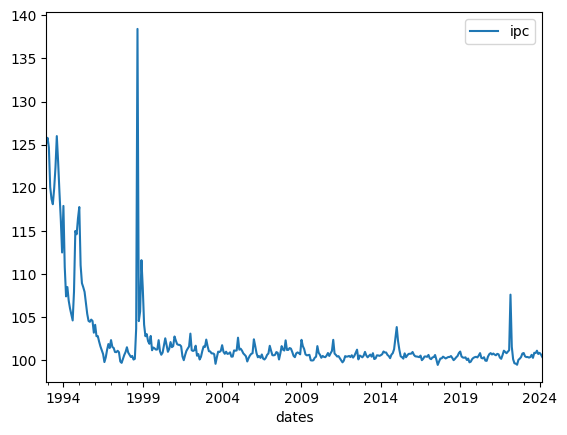

In [16]:
df.plot('dates', 'ipc')

<AxesSubplot: xlabel='dates'>

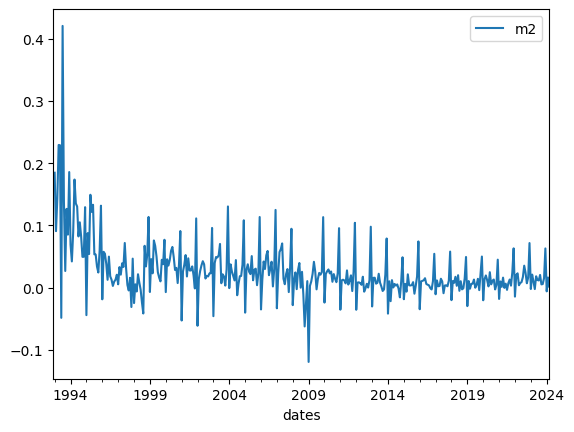

In [17]:
df.plot('dates', 'm2')

<AxesSubplot: xlabel='dates'>

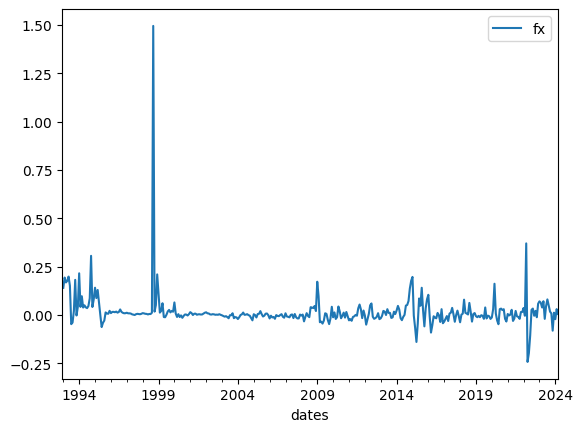

In [18]:
df.plot('dates', 'fx')

In [19]:
df = df[df['dates'] > '2000-01-01']

<AxesSubplot: xlabel='dates'>

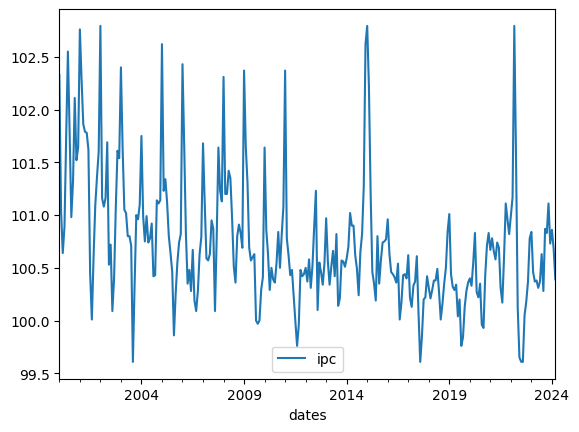

In [20]:
df.loc[df['ipc'] > df['ipc'].quantile(0.99), 'ipc'] = df['ipc'].quantile(0.99)
df.loc[df['ipc'] < df['ipc'].quantile(0.01), 'ipc'] = df['ipc'].quantile(0.01)
df.plot('dates', 'ipc')

<AxesSubplot: xlabel='dates'>

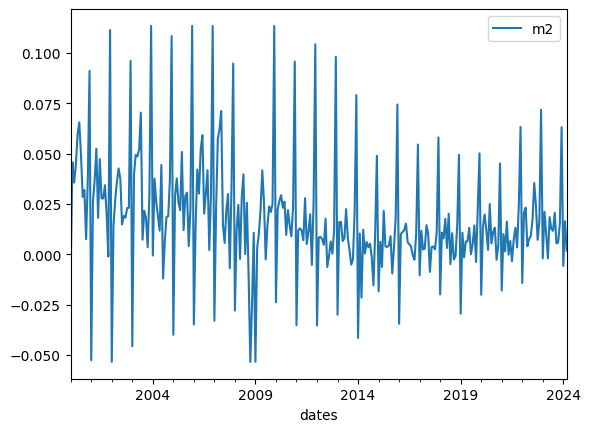

In [21]:
df.loc[df['m2'] > df['m2'].quantile(0.99), 'm2'] = df['m2'].quantile(0.99)
df.loc[df['m2'] < df['m2'].quantile(0.01), 'm2'] = df['m2'].quantile(0.01)
df.plot('dates', 'm2')

<AxesSubplot: xlabel='dates'>

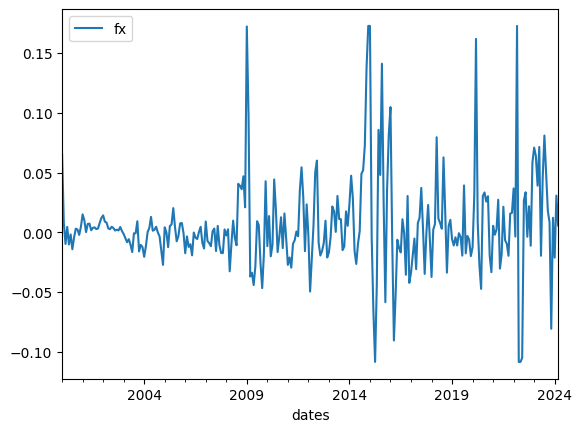

In [22]:
df.loc[df['fx'] > df['fx'].quantile(0.99), 'fx'] = df['fx'].quantile(0.99)
df.loc[df['fx'] < df['fx'].quantile(0.01), 'fx'] = df['fx'].quantile(0.01)
df.plot('dates', 'fx')

In [23]:
df.dropna(inplace = True)

In [24]:
df.head()

,dates,ipc,m2,fx
85,2000-01-31,102.33,-0.006997,0.065185
86,2000-02-29,101.04,0.045660,0.007891
87,2000-03-31,100.64,0.035580,-0.009743
88,2000-04-30,100.89,0.044378,0.004568
89,2000-05-31,101.75,0.059315,-0.010143


In [25]:
df['year'] = df['dates'].apply(lambda x: x.year)
df['month'] = df['dates'].apply(lambda x: x.month)
df.head()

,dates,ipc,m2,fx,year,month
85,2000-01-31,102.33,-0.006997,0.065185,2000,1
86,2000-02-29,101.04,0.045660,0.007891,2000,2
87,2000-03-31,100.64,0.035580,-0.009743,2000,3
88,2000-04-30,100.89,0.044378,0.004568,2000,4
89,2000-05-31,101.75,0.059315,-0.010143,2000,5


In [26]:
for l in range(1, 9):
    df['ipc_' + str(l)] = df['ipc'].shift(l)
    if l >= 6:
        df['m2_' + str(l)] = df['m2'].shift(l)
        df['fx_' + str(l)] = df['fx'].shift(l)
    else:
        df['year_' + str(l)] = df['year'].shift(l)
        df['month_' + str(l)] = df['month'].shift(l)

In [27]:
df.dropna(inplace = True)

In [28]:
df['dates'].values[208]

numpy.datetime64('2017-12-31T00:00:00.000000000')

In [29]:
dates = df['dates']
validation_date_start = df['dates'].values[208]
validation_date_end = df['dates'].values[-6]
dates_val = df[(df['dates'] >= validation_date_start) & (df['dates'] <= validation_date_end)]['dates']

In [30]:
params = dict(
    dates = dates_val,
    learning_rate=[0.1, 0.5],
    n_estimators = [100],
    subsample = [0.5, 1.0],
    max_depth = [3, 5, 7],
    min_samples_split = [2, 5, 9],
    min_samples_leaf = [2, 5, 9]
)

In [31]:
all_params = pd.DataFrame(columns = params.keys())

for row in it.product(*params.values()):
    all_params.loc[len(all_params.index)] = row

In [32]:
len(all_params)

7560

In [33]:
df.head()

,dates,ipc,m2,fx,year,month,ipc_1,year_1,month_1,ipc_2,...,month_5,ipc_6,m2_6,fx_6,ipc_7,m2_7,fx_7,ipc_8,m2_8,fx_8
93,2000-09-30,101.32,0.031915,0.003065,2000,9,100.98,2000.0,8.0,101.79,...,4.0,100.64,0.035580,-0.009743,101.04,0.045660,0.007891,102.33,-0.006997,0.065185
94,2000-10-31,102.11,0.007534,0.002337,2000,10,101.32,2000.0,9.0,100.98,...,5.0,100.89,0.044378,0.004568,100.64,0.035580,-0.009743,101.04,0.045660,0.007891
95,2000-11-30,101.52,0.037584,-0.002152,2000,11,102.11,2000.0,10.0,101.32,...,6.0,101.75,0.059315,-0.010143,100.89,0.044378,0.004568,100.64,0.035580,-0.009743
96,2000-12-31,101.64,0.091030,0.004673,2000,12,101.52,2000.0,11.0,102.11,...,7.0,102.55,0.065522,-0.001767,101.75,0.059315,-0.010143,100.89,0.044378,0.004568
97,2001-01-31,102.76,-0.052581,0.015027,2001,1,101.64,2000.0,12.0,101.52,...,8.0,101.79,0.049349,-0.014159,102.55,0.065522,-0.001767,101.75,0.059315,-0.010143


In [36]:
def get_model_results(data, date, par):
    
    par_dict = par.to_dict()
    
    data_train = data[data['dates'] < date]
    data_val = data[data['dates'] == date]
    
    y_train = data_train[['ipc', 'ipc_1', 'ipc_2', 'ipc_3', 'ipc_4', 'ipc_5']]
    x_train = data_train.drop(['dates', 'ipc', 'ipc_1', 'ipc_2', 'ipc_3', 'ipc_4', 'ipc_5', 'm2', 'fx'], axis=1)
        
    y_val = data_val[['ipc', 'ipc_1', 'ipc_2', 'ipc_3', 'ipc_4', 'ipc_5']]
    x_val = data_val.drop(['dates', 'ipc', 'ipc_1', 'ipc_2', 'ipc_3', 'ipc_4', 'ipc_5', 'm2', 'fx'], axis=1)
    
    iso_forest = IsolationForest()
    iso_forest.fit(x_train)
    x_train['outlier'] = iso_forest.predict(x_train)
    x_val['outlier'] = iso_forest.predict(x_val)
    
    gbr = MultiOutputRegressor(GradientBoostingRegressor(loss="quantile", alpha=0.5, **par_dict))
    gbr.fit(x_train, y_train)
    preds = gbr.predict(x_val)
    
    mae = mean_absolute_error(y_val, preds)
    
    return mae
    

In [37]:
all_params['mae'] = all_params.apply(lambda x: get_model_results(df, 
                                                                 x['dates'], 
                                                                 x[['learning_rate', 
                                                                    'n_estimators', 
                                                                    'subsample', 
                                                                    'max_depth',
                                                                    'min_samples_split',
                                                                    'min_samples_leaf']]), 
                                    axis = 1)

In [39]:
res_params = all_params.groupby(['learning_rate', 'n_estimators', 
            'subsample', 'max_depth',
            'min_samples_split', 'min_samples_leaf'])['mae'].mean()

In [54]:
min(res_params)

0.25021970411265654

In [53]:
best_params = res_params.index[np.argmin(res_params)]

In [55]:
best_params

(0.1, 100, 1.0, 5, 2, 2)

In [ ]:
#'learning_rate' = 0.1
#'n_estimators' = 100
#'subsample' = 1.0
#'max_depth' = 5 
#'min_samples_split' = 2
#'min_samples_leaf' = 2